# Hesotn model calibration

## Heston model definition

In Heston model the stock price is governed by the following system of SDE:
$$
    \begin{cases}
        \dfrac{dS_t}{S_t} = r dt + \sqrt{v_t} dW_t \\
        dv_t = k(\theta - v_t) + \sigma \sqrt{v_t} dZ_t, \;dW_t dZ_t = \rho dt
    \end{cases}
$$
with initial conditions $S_0, v_0$. The price of a call option can be expressed as follow:
$$
C(K, \tau | S_0) = S_0 \mathbb{P}_2( S_{\tau} > K ) - e^{-r\tau} K \mathbb{P}_1( S_{\tau} > K )
$$where $\mathbb{P}_1$ is risk neutral measure, $\mathbb{P}_2$ - is a measure with respect to which $e^{rt} / S_t$ is a martingale.

Let us denote parameters of heston model as $\vec{\alpha} = \left(v_0, \theta, \rho, k, \sigma\right)$ and introduce a function:
$$
\phi(u, \tau, \vec{\alpha}) = \exp \left( -\dfrac{i u k\theta\rho\tau}{\sigma} - Av_0 + \dfrac{2k\theta}{\sigma^2} D  \right)
$$where
$$
\begin{aligned}
    &\xi = k - i \sigma \rho u \\
    &d = \sqrt{\xi^2 + \sigma^2 (iu + u^2) } \\    
    &A_1 = \sinh \left( \dfrac{d\tau}{2} \right) \left(iu + u^2\right) \\
    &A_2 = d \cosh\left(\dfrac{d\tau}{2}\right) + \xi \sinh\left(\dfrac{d\tau}{2}\right)\\
    &A = \dfrac{A_1}{A_2}\\
    &D = \log d + \dfrac{(k-d)\tau}{2} - \log \left[ \dfrac{d+\xi}{2} + \dfrac{d-\xi}{2}e^{-d\tau}  \right]
\end{aligned}
$$

Let us denote $x = \log \left( \dfrac{ S_0 e^{r\tau} }{ K }  \right)$. Then we can calculate probabilites as follow:
$$
\begin{aligned}
&P_1 = \mathbb{P}_1( S_{\tau} > K ) = 0.5 + \Re \dfrac{1}{\pi} \int_0^{\infty} e^{iux}\phi(u, \tau, \vec{\alpha}) du\\
&P_2 = \mathbb{P}_2( S_{\tau} > K ) = 0.5 + \Re \dfrac{1}{\pi} \int_0^{\infty} e^{iux}\phi(u - i, \tau, \vec{\alpha}) du\\
\end{aligned}
$$

In order to calibrate option price surface we need to know the derivatives of the option price with respect to parameters $\vec{\alpha}$.
$$
\begin{aligned}
&\nabla P_1 = \Re \dfrac{1}{\pi} \int_0^{\infty} e^{iux}\phi(u, \tau, \vec{\alpha}) \vec{h}(u, \vec{\alpha}) du\\
&\nabla P_2 = \Re \dfrac{1}{\pi} \int_0^{\infty} e^{iux}\phi(u-i, \tau, \vec{\alpha}) \vec{h}(u-i, \vec{\alpha}) du\\
\end{aligned}
$$
where $\vec{h}(u, \tau, \vec{\alpha})$ is a gradient of $\log \phi$. For the elements of this vector we have explicit formulas:
$$
\begin{aligned}
    &h_1 = -A\\
    &h_2 = \dfrac{2 k}{\sigma^2}D - \dfrac{ik\rho \tau u }{\sigma}\\
    &h_3 = -\frac{i k \theta \tau u}{\sigma} - v_0 \dfrac{\partial A}{\partial \rho} + \dfrac{2 k \theta}{\sigma^2} \dfrac{\partial D}{\partial \rho}\\
    &h_4 = -\dfrac{i \theta \rho \tau u}{\sigma}- v_0 \dfrac{\partial A}{\partial k} + 2 \dfrac{\theta}{\sigma^2}D + \dfrac{2 k \theta}{\sigma^2}\dfrac{\partial D}{\partial k}\\
    &h_5 = \dfrac{i k \theta \rho \tau u}{\sigma^2} - v_0 \dfrac{\partial A}{\partial \sigma} - \dfrac{4k\theta}{\sigma^3}D + \dfrac{2 k \theta}{\sigma^2}\dfrac{\partial D}{\partial \sigma}\\
\end{aligned}
$$

Heston model can be easily generalized to the double volatility model:

$$
    \begin{cases}
        &\dfrac{dS_t}{S_t} = r dt + \sum\limits_{i=1}^{D} \sqrt{v^i_t} dW_t^i\\
        &dv^i_t = k^i(\theta^i - v^i_t) + \sigma^i \sqrt{v^i_t} dZ^i_t\\
        & dW_t^i dZ_t^i = \rho_i dt \\
        & dZ_t^i dZ_t^j = \delta_{ij} dt\\
        & dW_t^i dW_t^j = \delta_{ij} dt
    \end{cases}
$$

Let $\vec{\alpha} = \left( \vec{\alpha}_1, \vec{\alpha}_2, \ldots, \vec{\alpha}_D \right)$ and
$$
\Phi(u, \tau, \vec{\alpha}) = \prod_{i=1}^D \phi(u, \tau, \vec{\alpha_i})
$$Then
$$
\begin{aligned}
    &P_1 = \mathbb{P}_1( S_{\tau} > K ) = 0.5 + \Re \dfrac{1}{\pi} \int_0^{\infty} e^{iux}\Phi(u, \tau, \vec{\alpha}) du\\
    &P_2 = \mathbb{P}_2( S_{\tau} > K ) = 0.5 + \Re \dfrac{1}{\pi} \int_0^{\infty} e^{iux}\Phi(u - i, \tau, \vec{\alpha}) du\\
    \end{aligned}
$$
and 
$$
\begin{aligned}
    &\nabla_{\vec{\alpha_i}} P_1 = \Re \dfrac{1}{\pi} \int_0^{\infty} e^{iux}\Phi(u, \tau, \vec{\alpha}) \vec{h}(u, \tau, \vec{\alpha}_i) du \\
    &\nabla P_1 = \left( \nabla_{\vec{\alpha_1}} P_1, \ldots, \nabla_{\vec{\alpha_D}} P_1\right)
\end{aligned}
$$

# Get data

In [1]:
def download_data():
    '''
        download historial data from deribit exchange
    '''
    import nest_asyncio
    nest_asyncio.apply()
    from tardis_dev import datasets
    
    datasets.download(
        exchange="deribit",
        data_types=["options_chain"],
        from_date="2022-09-01",
        to_date="2022-09-02",
        symbols=["OPTIONS"]
    )
    
    !gzip -d datasets/*.gz

In [2]:
import os.path

fname = './datasets/deribit_options_chain_2022-09-01_OPTIONS.csv'
if not os.path.isfile(fname):
    download_data()

In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)

In [4]:
from heston import Heston
from heston_calibration import HestonCalibrator
from black_scholes import black_scholes, implied_volatility

In [5]:
#load dataset to the memory
df = pd.read_csv(fname, nrows=200000)

In [6]:
#list of all available instrument
set(df.underlying_index)

{'BTC-28OCT22',
 'BTC-2SEP22',
 'BTC-30DEC22',
 'BTC-30JUN23',
 'BTC-30SEP22',
 'BTC-31MAR23',
 'BTC-9SEP22',
 'ETH-28OCT22',
 'ETH-2SEP22',
 'ETH-30DEC22',
 'ETH-30JUN23',
 'ETH-30SEP22',
 'ETH-31MAR23',
 'ETH-9SEP22',
 'SOL-28OCT22',
 'SOL-2SEP22',
 'SOL-30SEP22',
 'SOL-9SEP22',
 'SYN.BTC-16SEP22',
 'SYN.BTC-1SEP22',
 'SYN.BTC-25NOV22',
 'SYN.ETH-16SEP22',
 'SYN.ETH-1SEP22',
 'SYN.ETH-25NOV22',
 'SYN.SOL-1SEP22'}

In [7]:
df.head(10)

,exchange,symbol,timestamp,local_timestamp,type,strike_price,expiration,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_index,underlying_price,delta,gamma,vega,theta,rho
0,deribit,ETH-30DEC22-1300-P,1661990399996000,1661990400002270,put,1300,1672387200000000,8046.0,0.1375,0.1465,123.0,101.36,0.1490,121.0,102.64,0.1478,102.05,ETH-30DEC22,1523.1100,-0.28662,0.00038,2.97707,-1.26233,-2.18163
1,deribit,ETH-30DEC22-15000-P,1661990400007000,1661990400011122,put,15000,1672387200000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.8488,135.30,ETH-30DEC22,1523.1100,-0.99470,0.00001,0.13314,-0.07485,-49.43078
2,deribit,ETH-31MAR23-4500-P,1661990400048000,1661990400061948,put,4500,1680249600000000,16.0,1.2695,NaN,NaN,NaN,2.2620,1.0,200.16,1.9889,97.66,ETH-31MAR23,1525.6200,-0.86084,0.00020,2.57325,-0.59455,-25.17323
3,deribit,ETH-25NOV22-1600-P,1661990400063000,1661990400073423,put,1600,1669363200000000,273.0,0.2170,0.2205,138.0,99.45,0.2240,101.0,101.29,0.2235,101.04,SYN.ETH-25NOV22,1524.3589,-0.44230,0.00053,2.90962,-1.72252,-2.37288
4,deribit,ETH-25NOV22-1600-P,1661990400096000,1661990400106456,put,1600,1669363200000000,273.0,0.2170,0.2205,138.0,99.45,0.2240,252.0,101.29,0.2235,101.04,SYN.ETH-25NOV22,1524.3589,-0.44230,0.00053,2.90962,-1.72252,-2.37288
5,deribit,BTC-30DEC22-21000-P,1661990400145000,1661990400153970,put,21000,1672387200000000,286.8,0.1795,0.1825,10.5,67.51,0.1900,8.0,70.80,0.1861,69.09,BTC-30DEC22,20038.5100,-0.46804,0.00005,45.75363,-13.13423,-43.21403
6,deribit,BTC-30DEC22-20000-P,1661990400150000,1661990400159447,put,20000,1672387200000000,1363.6,0.1530,0.1560,27.0,69.04,0.1595,8.0,70.60,0.1572,69.56,BTC-30DEC22,20038.5100,-0.41897,0.00005,44.95096,-12.99261,-38.06227
7,deribit,ETH-30DEC22-1300-P,1661990400152000,1661990400160133,put,1300,1672387200000000,8046.0,0.1375,0.1470,1.0,101.61,0.1490,121.0,102.64,0.1478,102.05,ETH-30DEC22,1523.1100,-0.28662,0.00038,2.97707,-1.26233,-2.18163
8,deribit,BTC-28OCT22-23000-C,1661990400192000,1661990400195281,call,23000,1666944000000000,202.1,0.0525,0.0520,18.2,65.66,0.0530,7.9,66.35,0.0523,65.89,BTC-28OCT22,20010.6600,0.34363,0.00007,29.17678,-16.76600,9.15609
9,deribit,ETH-25NOV22-2400-P,1661990400207000,1661990400217444,put,2400,1669363200000000,0.0,NaN,NaN,NaN,NaN,0.8120,1.0,200.04,0.6286,98.93,SYN.ETH-25NOV22,1524.3589,-0.76107,0.00043,2.28573,-1.32493,-4.95222


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   exchange          200000 non-null  object 
 1   symbol            200000 non-null  object 
 2   timestamp         200000 non-null  int64  
 3   local_timestamp   200000 non-null  int64  
 4   type              200000 non-null  object 
 5   strike_price      200000 non-null  int64  
 6   expiration        200000 non-null  int64  
 7   open_interest     200000 non-null  float64
 8   last_price        161457 non-null  float64
 9   bid_price         122469 non-null  float64
 10  bid_amount        122469 non-null  float64
 11  bid_iv            107341 non-null  float64
 12  ask_price         154459 non-null  float64
 13  ask_amount        154459 non-null  float64
 14  ask_iv            154459 non-null  float64
 15  mark_price        200000 non-null  float64
 16  mark_iv           20

## Select options on BTC

In [9]:
def select_data(df: pd.DataFrame):
    btc_ind = [symbol.startswith('BTC') for symbol in df.underlying_index]

    columns_to_drop = ['exchange', 'symbol', 'local_timestamp', 'underlying_index', 
                       'delta', 'gamma', 'vega', 'theta', 'rho']
    
    btc = df[btc_ind].reset_index(drop=True).drop(columns_to_drop, axis=1)

    #tau is time before expiration in years
    btc['tau'] = (btc.expiration - btc.timestamp) / 1e6 / 3600 / 24 / 365
    #days before exp
    btc['days'] = (btc['tau'] * 365).astype(int)

    K = btc.strike_price.values
    F = btc.underlying_price.values

    payoff = np.maximum( F - K, 0.0 )
    payoff[btc.type == 'put'] = np.maximum( K - F, 0.0)[btc.type == 'put']

    btc["payoff"] = payoff

    btc['mid_price'] = 0.5 * (btc.ask_price + btc.bid_price)
    
    btc_grouped = btc.groupby(['type', 'expiration', 'strike_price'])\
    .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)
    
    put = btc_grouped[btc_grouped.type == 'put'].drop(['type'], axis=1).reset_index(drop=True)

    call = btc_grouped[btc_grouped.type == 'call'].drop(['type'], axis=1).reset_index(drop=True)
    
    return put, call

In [10]:
put, call = select_data(df)

In [11]:
put.head(10)

,expiration,strike_price,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_price,tau,days,payoff,mid_price
0,1662105600000000,13000,20.5,0.0010,NaN,NaN,NaN,0.0005,34.0,309.42,0.0000,127.05,20087.59,0.003641,1,0.00,NaN
1,1662105600000000,14000,38.4,0.0005,NaN,NaN,NaN,0.0005,42.5,261.68,0.0000,127.05,20087.59,0.003641,1,0.00,NaN
2,1662105600000000,15000,130.0,0.0005,NaN,NaN,NaN,0.0005,39.0,216.69,0.0000,120.27,20087.59,0.003641,1,0.00,NaN
3,1662105600000000,16000,578.2,0.0005,NaN,NaN,NaN,0.0010,89.0,193.13,0.0000,101.18,20087.59,0.003641,1,0.00,NaN
4,1662105600000000,17000,579.9,0.0005,NaN,NaN,NaN,0.0005,11.0,132.83,0.0000,95.26,20087.59,0.003641,1,0.00,NaN
5,1662105600000000,18000,3570.2,0.0005,NaN,NaN,NaN,0.0005,12.0,92.77,0.0004,88.26,20087.92,0.003641,1,0.00,NaN
6,1662105600000000,19000,2387.5,0.0020,0.0020,15.4,71.98,0.0025,20.5,76.60,0.0022,74.19,20087.66,0.003641,1,0.00,0.00225
7,1662105600000000,19500,932.7,0.0065,0.0050,7.3,64.98,0.0055,13.4,67.76,0.0052,66.41,20088.07,0.003641,1,0.00,0.00525
8,1662105600000000,20000,1362.8,0.0135,0.0115,39.9,56.46,0.0130,27.1,62.76,0.0124,60.35,20087.18,0.003640,1,0.00,0.01225
9,1662105600000000,20500,672.5,0.0200,0.0255,14.2,52.09,0.0275,28.6,61.90,0.0266,57.68,20087.35,0.003641,1,412.65,0.02650


In [12]:
call.head(10)

,expiration,strike_price,open_interest,last_price,bid_price,bid_amount,bid_iv,ask_price,ask_amount,ask_iv,mark_price,mark_iv,underlying_price,tau,days,payoff,mid_price
0,1662105600000000,13000,0.0,NaN,0.2425,3.0,NaN,0.4480,3.0,500.00,0.3528,127.05,20087.35,0.003641,1,7087.35,0.34525
1,1662105600000000,14000,0.0,NaN,0.1925,3.0,NaN,0.3980,3.0,500.00,0.3031,127.05,20087.92,0.003641,1,6087.92,0.29525
2,1662105600000000,15000,0.0,NaN,0.1430,3.0,NaN,0.3485,3.0,500.00,0.2533,120.27,20087.35,0.003641,1,5087.35,0.24575
3,1662105600000000,16000,0.0,NaN,0.0930,3.0,NaN,0.2985,3.0,500.00,0.2035,101.18,20087.92,0.003641,1,4087.92,0.19575
4,1662105600000000,17000,0.0,NaN,0.0435,3.0,NaN,0.2490,3.0,500.00,0.1537,95.26,20087.35,0.003641,1,3087.35,0.14625
5,1662105600000000,18000,0.0,NaN,NaN,NaN,NaN,0.1995,3.0,500.00,0.1043,88.26,20087.35,0.003641,1,2087.35,NaN
6,1662105600000000,19000,8.9,0.0420,0.0055,2.0,NaN,0.1515,3.3,500.00,0.0564,74.19,20087.92,0.003641,1,1087.92,0.07850
7,1662105600000000,19500,52.4,0.0350,0.0330,7.4,57.59,0.0365,8.2,76.96,0.0345,66.41,20087.92,0.003641,1,587.92,0.03475
8,1662105600000000,20000,604.0,0.0140,0.0160,16.0,57.09,0.0170,3.8,61.29,0.0168,60.35,20087.59,0.003641,1,87.59,0.01650
9,1662105600000000,20500,633.3,0.0065,0.0055,6.5,54.83,0.0060,0.1,57.29,0.0061,57.68,20087.18,0.003640,1,0.00,0.00575


## Volatility smile

In [13]:
days = set(call.days.values)
days

{1, 8, 29, 57, 120, 211, 302}

In [14]:
day = 120

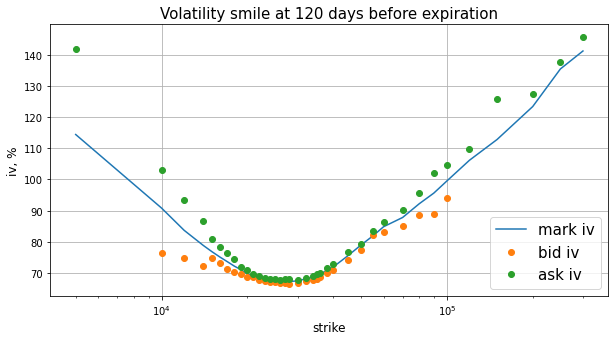

In [15]:
day = 120
call_ = call[call.days == day]

plt.figure(figsize=(10, 5))
plt.title(f"Volatility smile at {day} days before expiration", fontsize=15)
plt.semilogx(call_.strike_price, call_.mark_iv, label='mark iv')
plt.semilogx(call_.strike_price, call_.bid_iv, 'o', label='bid iv')
plt.semilogx(call_.strike_price, call_.ask_iv, 'o', label='ask iv')
plt.ylabel("iv, %", fontsize=12)
plt.xlabel("strike", fontsize=12)
plt.legend(fontsize=15)
plt.grid()

# Calibration

In [16]:
call.columns

Index(['expiration', 'strike_price', 'open_interest', 'last_price',
       'bid_price', 'bid_amount', 'bid_iv', 'ask_price', 'ask_amount',
       'ask_iv', 'mark_price', 'mark_iv', 'underlying_price', 'tau', 'days',
       'payoff', 'mid_price'],
      dtype='object')

In [17]:
def get_data_from_df(df : pd.DataFrame):
    """
        This function extracts out the money data from given dataframe
        
        Args:
            df(pd.DataFrame): dataframe of market data
            
        Returns:
            c(np.ndarray): option prices 
            iv(np.ndarray): implied vols
            K(np.ndarray): strikes
            F(np.ndarray): underlying prices
            T(np.ndarray): expiration times
            weights(np.ndarray): weights
    """
    
    #choose only out of the money options
    ind = (df.payoff == 0.0) & (~np.isnan(df.mid_price).values)
    df_ = df[ind].copy().reset_index(drop=True)
    
    #future price
    F = df_.underlying_price.values
    #strike
    K = df_.strike_price.values
    #time to exp
    T = df_.tau.values
    
    iv = 0.5 * ( df_.ask_iv.values + df_.bid_iv.values ) / 100.0
    c = df_.mid_price.values * F
    #weigths are propotional to open interest
    interest = df_.open_interest.values
    #weights
    weights = interest
    weights = weights / np.sum(weights)
    
    return c, iv, K, F, T, weights

def get_data_from_dfs(put:pd.DataFrame, call:pd.DataFrame):
    """
        This function extracts data from two dataframes for calls and puts and concatenates it
        
        Args:
            put(pd.DataFrame): dataframe with market data
            call(pd.DataFrame): dataframe with market data      
        
        Returns:
            c(np.ndarray): option prices 
            iv(np.ndarray): implied vols
            K(np.ndarray): strikes
            F(np.ndarray): underlying prices
            T(np.ndarray): expiration times
            weights(np.ndarray): weights
            typ(np.ndarray): list of types of an option, if True -- call option, else Put option
    """
    data_call = np.stack(get_data_from_df(call))
    data_put = np.stack(get_data_from_df(put))
    
    data = np.concatenate( (data_call, data_put), axis=-1)
    
    c, iv, K, F, T, weights = data
    
    typ = np.asarray([True] * data_call.shape[1] + [False] * data_put.shape[1])
    
    return c, iv, K, F, T, weights, typ

## Calibrating model on options with 120 days to expiration

In [18]:
day = 120

In [19]:
#extract data corresponding to day_before_exp = 120
X, iv, K, F, T, weights, typ = get_data_from_dfs(put[put.days == day], call[call.days == day])

weights = np.ones_like(X)

weights = weights / np.sum(weights)

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 130.54it/s]


2.5026918620081666


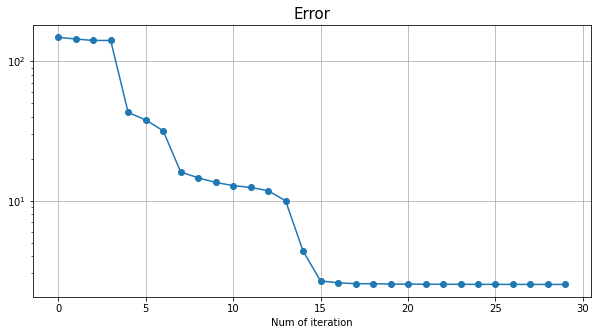

In [20]:
#create sabr calibrator object
heston_calib = HestonCalibrator(interest_rate=0.0, n_dim=1, n_int=200)
#call fit function
fs = heston_calib.fit(X, K, F, T, typ, Niter=30, weights=weights)
#save fitted model
heston = heston_calib.get_model()
#plot error
plt.figure(figsize=(10, 5))
plt.title("Error", fontsize=15)
plt.semilogy(fs, '-o')
plt.xlabel("Num of iteration")
plt.grid()

print(fs[-1])

In [21]:
names = ["v_0", "theta", "rho", "k", "sigma"]

In [22]:
print("optimized parameters:", *zip(names, (heston.heston_params).round(5)), sep='\n' )

optimized parameters:
('v_0', 0.15956)
('theta', 5.0)
('rho', -0.33438)
('k', 0.58978)
('sigma', 2.62099)


## Calculating option prices for calibrated parameters

In [23]:
call_ = call[call.days == day]
put_  = put[put.days == day]

#make prediction on the whole data
#remember, we were fitting only on out of the money options
C_calib, ivc_calib = heston( call_.strike_price.values, call_.underlying_price.values, call_.tau.values, True )
P_calib, ivp_calib = heston( put_.strike_price.values, put_.underlying_price.values, put_.tau.values, False )

In [24]:
#extract mark and market implied volatility
iv_mark = call_.mark_iv.values
iv_market = 0.5 * ( call_.ask_iv.values + call_.bid_iv.values )

mark_price = call_.mark_price.values * call_.underlying_price.values
mid_price  = call_.mid_price.values * call_.underlying_price.values

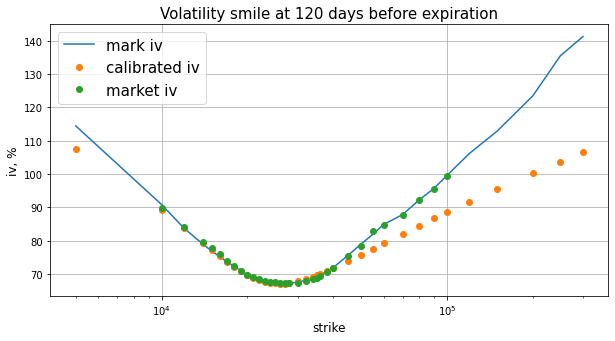

In [25]:
plt.figure(figsize=(10, 5))
plt.title(f"Volatility smile at {day} days before expiration", fontsize=15)
plt.semilogx(call_.strike_price.values, iv_mark, label='mark iv')
plt.semilogx(call_.strike_price.values, 100 * ivc_calib, 'o', label='calibrated iv')
plt.semilogx(call_.strike_price.values, iv_market, 'o', label='market iv')
plt.ylabel("iv, %", fontsize=12)
plt.xlabel("strike", fontsize=12)
plt.legend(fontsize=15)
plt.grid()

In [26]:
error = np.linalg.norm( 100 * ivc_calib - iv_mark ) / np.linalg.norm( iv_mark ) * 100

print(f"error in iv = {error:.4f}%")

error = np.linalg.norm(  C_calib - mark_price ) / np.linalg.norm( mark_price ) * 100

print(f"error in price = {error:.4f}%")

error in iv = 11.5390%
error in price = 0.3293%


In [27]:
C_mark = call_.mark_price * call_.underlying_price
P_mark = put_.mark_price * put_.underlying_price
error_call = 100 * np.linalg.norm(C_mark - C_calib) / np.linalg.norm(C_mark)
error_put = 100 * np.linalg.norm(P_mark - P_calib) / np.linalg.norm(P_mark)

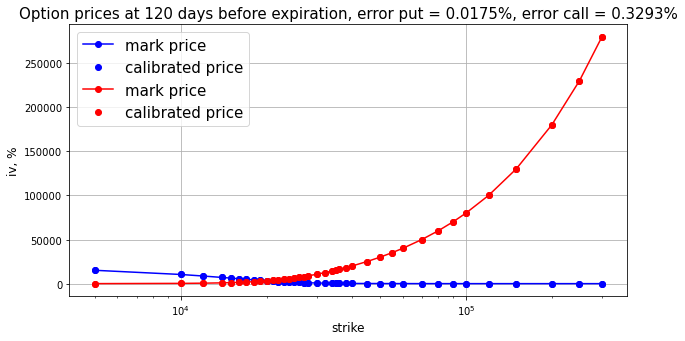

In [28]:
plt.figure(figsize=(10, 5))
plt.title(f"Option prices at {day} days before expiration, error put = {error_put:.4f}%, error call = {error_call:.4f}%", fontsize=15)
plt.semilogx(call_.strike_price.values, C_mark, '-ob',label='mark price')
plt.semilogx(call_.strike_price.values, C_calib, 'ob', label='calibrated price')

plt.semilogx(put_.strike_price.values, P_mark, '-or',label='mark price')
plt.semilogx(put_.strike_price.values, P_calib, 'or', label='calibrated price')


plt.ylabel("iv, %", fontsize=12)
plt.xlabel("strike", fontsize=12)
plt.legend(fontsize=15)
plt.grid()


## Calibrating SABR model on the whole dataset:

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.66it/s]


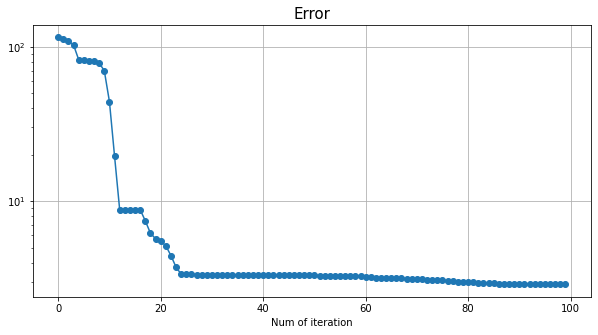

In [29]:
X, iv, K, F, T, weights, typ = get_data_from_dfs(put, call)

weights = np.ones_like(X)

weights = weights / np.sum(weights)

#create heston calibrator object
heston_calib = HestonCalibrator(interest_rate=0.0, n_dim=1, n_int=200)
#call fit function
fs = heston_calib.fit(X, K, F, T, typ, Niter=100, weights=weights)
#save fitted model
heston = heston_calib.get_model()

#plot error
plt.figure(figsize=(10, 5))
plt.title("Error", fontsize=15)
plt.semilogy(fs, '-o')
plt.xlabel("Num of iteration")
plt.grid()

In [30]:
fs[-1]

2.88353263164589

In [31]:
print("optimized parameters:", *zip(names, (heston.heston_params).round(5)), sep='\n' )

optimized parameters:
('v_0', 0.4788)
('theta', 0.74886)
('rho', -0.24039)
('k', 4.09994)
('sigma', 3.51261)


## Plot results

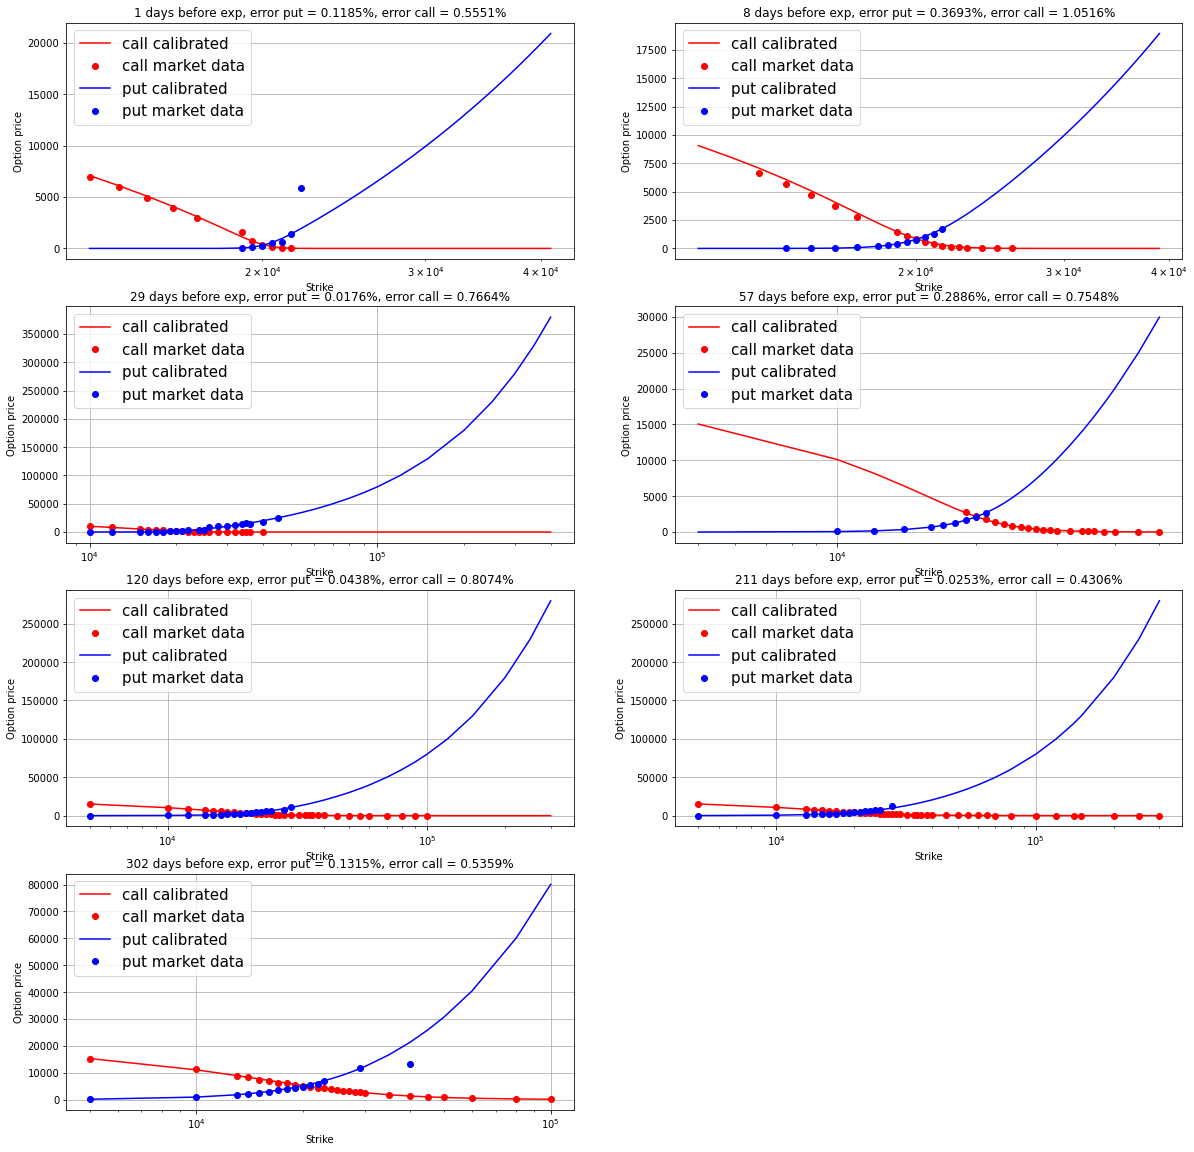

In [32]:
i = 1
plt.figure(figsize=(20, 20))
for (d, call_), (_, put_) in zip(call.groupby('days'), put.groupby('days')):
    
    K = call_.strike_price.values
    F = call_.underlying_price.values
    T = call_.tau.values
    
    #calibrated price and iv
    C_calib, iv_calib = heston(K, F, T, True)
    #mid price
    C_mid = call_.mid_price.values * F
    #mark_price
    C_mark = call_.mark_price.values * F 
    
    ax = ax = plt.subplot(4, 2, i)
    ax.semilogx(K, C_calib, '-r', label='call calibrated')
    ax.semilogx(K, C_mid,   'ro', label='call market data')
    
    K = put_.strike_price.values
    F = put_.underlying_price.values
    T = put_.tau.values
    
    #calibrated price and iv
    P_calib, iv_calib = heston(K, F, T, False)
    #mid price
    P_mid = put_.mid_price.values * F
    #mark_price
    P_mark = put_.mark_price.values * F 

    ax.semilogx(K, P_calib, '-b', label='put calibrated')
    ax.semilogx(K, P_mid,   'bo', label='put market data')
    
    
    error_call = 100 * np.linalg.norm(C_mark - C_calib) / np.linalg.norm(C_mark)
    error_put = 100 * np.linalg.norm(P_mark - P_calib) / np.linalg.norm(P_mark)

    
    ax.legend(fontsize=15)
    ax.set_title(f"{d} days before exp, error put = {error_put:.4f}%, error call = {error_call:.4f}%", fontsize=12)
    ax.grid()
    
    ax.set_xlabel("Strike")
    ax.set_ylabel("Option price")
    
    i += 1

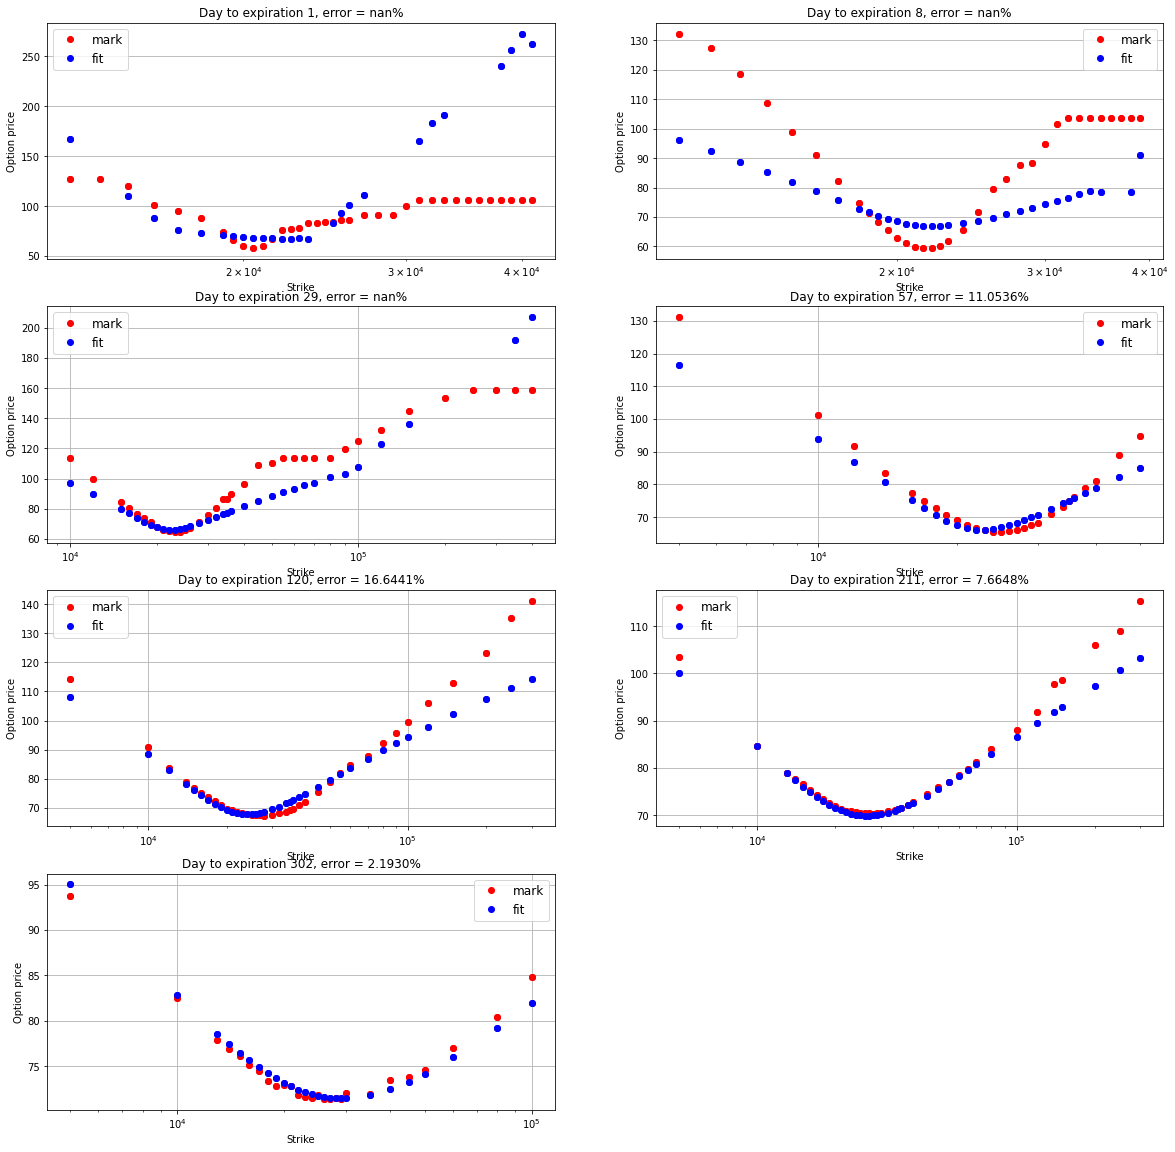

In [33]:
i = 1
plt.figure(figsize=(20, 20))
for (d, call_), (_, put_) in zip(call.groupby('days'), put.groupby('days')):
    
    K = call_.strike_price.values
    F = call_.underlying_price.values
    T = call_.tau.values
    
    #calibrated price and iv
    C_calib, ivc_calib = heston(K, F, T, True)
    
    iv_mark = call_.mark_iv.values
    ax = plt.subplot(4, 2, i)
    ax.semilogx(K, iv_mark, 'or', label='mark')
    ax.semilogx(K, ivc_calib * 100, 'ob', label='fit')
    
    err_call = np.linalg.norm( 100 * ivc_calib - iv_mark ) / np.linalg.norm( iv_mark ) * 100

    
    K = put_.strike_price.values
    F = put_.underlying_price.values
    T = put_.tau.values
    
    #calibrated price and iv
    P_calib, ivp_calib = heston(K, F, T, False)
    iv_mark = put_.mark_iv.values
    ax.semilogx(K, iv_mark, 'or')
    ax.semilogx(K, ivp_calib * 100, 'ob')
    
    err_put = np.linalg.norm( 100 * ivp_calib - iv_mark ) / np.linalg.norm( iv_mark ) * 100
    
    ax.set_title(f'Day to expiration {d}, error = {err_call + err_put:.4f}%')
    ax.grid()
    
    ax.set_xlabel("Strike")
    ax.set_ylabel("Option price")
    ax.legend(fontsize=12)
    i += 1